# Austin Animal Shelter: What puts an animal at risk of having a longer adoption time?
This analysis is based on [Austin Animal Shelter](http://www.austintexas.gov/department/aac) data from 2014 to 2018. Data are available through [Kaggle](https://www.kaggle.com/aaronschlegel/austin-animal-center-shelter-intakes-and-outcomes#aac_intakes_outcomes.csv).

<img src="http://www.austintexas.gov/sites/default/files/aac_logo.jpg" width=400px align="center"><br>
[Image Credit](http://www.austintexas.gov/department/aac)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings; warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('aac_intakes_outcomes.csv', parse_dates=True)

# Dataset Overview

In [3]:
df.shape

(79672, 41)

In [4]:
df.head()

,age_upon_outcome,animal_id_outcome,date_of_birth,outcome_subtype,outcome_type,sex_upon_outcome,age_upon_outcome_(days),age_upon_outcome_(years),age_upon_outcome_age_group,outcome_datetime,...,age_upon_intake_age_group,intake_datetime,intake_month,intake_year,intake_monthyear,intake_weekday,intake_hour,intake_number,time_in_shelter,time_in_shelter_days
0,10 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,3650,10.0,"(7.5, 10.0]",2017-12-07 14:07:00,...,"(7.5, 10.0]",2017-12-07 00:00:00,12,2017,2017-12,Thursday,14,1.0,0 days 14:07:00.000000000,0.588194
1,7 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2555,7.0,"(5.0, 7.5]",2014-12-20 16:35:00,...,"(5.0, 7.5]",2014-12-19 10:21:00,12,2014,2014-12,Friday,10,2.0,1 days 06:14:00.000000000,1.259722
2,6 years,A006100,2007-07-09 00:00:00,NaN,Return to Owner,Neutered Male,2190,6.0,"(5.0, 7.5]",2014-03-08 17:10:00,...,"(5.0, 7.5]",2014-03-07 14:26:00,3,2014,2014-03,Friday,14,3.0,1 days 02:44:00.000000000,1.113889
3,10 years,A047759,2004-04-02 00:00:00,Partner,Transfer,Neutered Male,3650,10.0,"(7.5, 10.0]",2014-04-07 15:12:00,...,"(7.5, 10.0]",2014-04-02 15:55:00,4,2014,2014-04,Wednesday,15,1.0,4 days 23:17:00.000000000,4.970139
4,16 years,A134067,1997-10-16 00:00:00,NaN,Return to Owner,Neutered Male,5840,16.0,"(15.0, 17.5]",2013-11-16 11:54:00,...,"(15.0, 17.5]",2013-11-16 09:02:00,11,2013,2013-11,Saturday,9,1.0,0 days 02:52:00.000000000,0.119444


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 79672 entries, 0 to 79671
Data columns (total 41 columns):
age_upon_outcome              79672 non-null object
animal_id_outcome             79672 non-null object
date_of_birth                 79672 non-null object
outcome_subtype               36348 non-null object
outcome_type                  79662 non-null object
sex_upon_outcome              79671 non-null object
age_upon_outcome_(days)       79672 non-null int64
age_upon_outcome_(years)      79672 non-null float64
age_upon_outcome_age_group    79672 non-null object
outcome_datetime              79672 non-null object
outcome_month                 79672 non-null int64
outcome_year                  79672 non-null int64
outcome_monthyear             79672 non-null object
outcome_weekday               79672 non-null object
outcome_hour                  79672 non-null int64
outcome_number                79672 non-null float64
dob_year                      79672 non-null int64
dob_month 

In [6]:
df.outcome_datetime = pd.to_datetime(df.outcome_datetime)

# Cats have longer adoption times than other animals.
- This dataset includes data for dogs, cats, birds, and "other", which include animals such as rabbits. 
- Dogs were the most common animal type.

<img src="https://icatcare.org/app/uploads/2018/07/Thinking-of-getting-a-cat.png" width=400px align="center"><br>
[Image Credit](https://icatcare.org/advice/thinking-of-getting-a-cat/)

In [8]:
df['animal_type'].unique()

array(['Dog', 'Cat', 'Other', 'Bird'], dtype=object)

In [9]:
df['animal_type'].describe()

count     79672
unique        4
top         Dog
freq      45366
Name: animal_type, dtype: object

Text(0, 0.5, 'Time in Shelter (Days)')

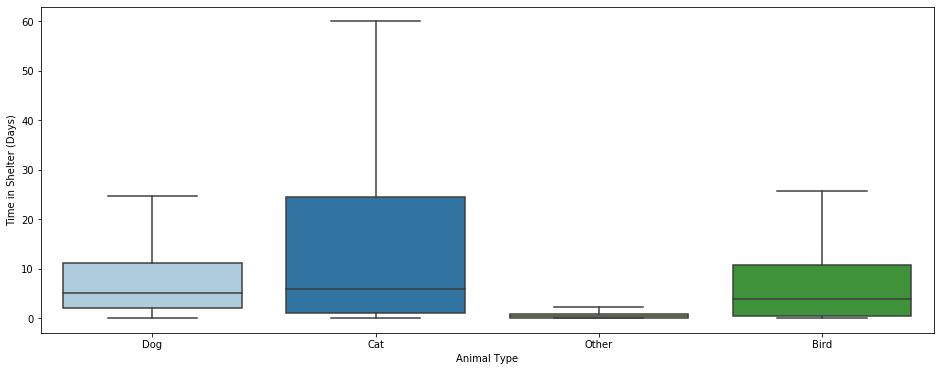

In [124]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', data=df, showfliers=False)
plt.xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

Although dogs are more common in this dataset, they take less time on average to adoption than cats.

***
# A closer look at man's best friend
What puts a dog at a higher risk of having a long adoption time?

<img src="http://wholesolutionsgroup.com/wp-content/uploads/2016/08/Man-and-Dog--1080x675.jpg" width=400px align=center><br>
[Image Credit](http://wholesolutionsgroup.com/why-dogs-are-mans-best-friend/)

## Does dog breed affect adoption time?
In this section, I hypothesized that stereotypically common shelter breeds, such as ***Pit Bulls and Chihuahuas***,  have longer adoption times than other breeds. 

<img src="https://assets3.thrillist.com/v1/image/2775369/size/tmg-article_tall.jpg" width=400px align="center"><br>
[Image Credit](https://www.thedodo.com/close-to-home/pit-bull-dog-carries-chihuahua-friend)

In [11]:
dogs = df[df['animal_type'] == 'Dog']
cats = df[df['animal_type'] == 'Cat']
birds = df[df['animal_type'] == 'Bird']
other = df[df['animal_type'] == 'Other']

### Pit bulls and chihuahuas do represent the most common breeds at this shelter.

In [13]:
dogs['breed'].value_counts().head()

Pit Bull Mix                 6256
Chihuahua Shorthair Mix      4831
Labrador Retriever Mix       4789
German Shepherd Mix          1950
Australian Cattle Dog Mix    1099
Name: breed, dtype: int64

Because many of the animals at this shelter were categorized as mixed breeds, it became impossible to see patterns by breed - there were 1919 unique breed categorizations. To simplify this analysis, I sorted the data such that each breed is a unique column, and each animal has a 1 or 0 based on whether it is in part or full that breed. I further created a mixed breed/purebred column to later analyze whether purebreds are adopted more quickly than mixed breeds.

In [12]:
dogs['breed'].nunique()

1919

In [66]:
dogs['breed'] = dogs['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dogs['breed'] = dogs['breed'].str.replace(' Shorthair', '')
dogs['breed'] = dogs['breed'].str.replace(' Longhair', '')
dogs['breed_nomix'] = dogs['breed'].str.replace(' Mix', '')
dogs['breed_list'] = dogs['breed_nomix'].str.split('/')
dogs.loc[dogs.breed_list.str.len()>1, 'mixed_breed'] = 'Mixed Breed'
dogs.loc[dogs['breed'].str.contains('Mix'), 'mixed_breed'] = 'Mixed Breed'
dogs['mixed_breed'] = dogs['mixed_breed'].fillna('Purebred')
#dogs.sort_index(axis=0)

In [15]:
has_breeds = pd.get_dummies(dogs['breed_list'].apply(pd.Series).stack()).sum(level=0)

In [16]:
dog_breeds_combined = pd.concat([dogs, has_breeds], axis=1)

In [17]:
breed_melt1 = dog_breeds_combined[['breed_list', 'mixed_breed', 'time_in_shelter_days']]
breed_melt2 = dog_breeds_combined.loc[:, 'Affenpinscher':]
breed_melt = pd.concat([breed_melt1, breed_melt2], axis=1)
dog_breeds = pd.melt(breed_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], 
                       var_name='breed_name', value_name='has_breed')
dog_breeds.loc[dog_breeds['has_breed']==1, 'breed'] = dog_breeds['breed_name']

#### I grouped dog breeds that occur <400 times into a group called "other" to see only the most common breeds.

In [78]:
common_breeds = dog_breeds.groupby('breed').sum()
common_breeds = common_breeds.sort_values('has_breed', ascending=False)
other_breeds = common_breeds.loc[common_breeds['has_breed']<400,:]
other_breeds_list = other_breeds.index.tolist()

In [67]:
dog_breeds.loc[dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = 'Other'
dog_breeds.loc[~dog_breeds['breed'].isin(other_breeds_list), 'breed_category'] = dog_breeds['breed']

In [107]:
sortgroup = dog_breeds.groupby('breed_category').mean().sort_values('time_in_shelter_days', ascending=False)
sortgroup = sortgroup['time_in_shelter_days'].to_dict()

## American Bull Dogs and Staffordshires beat out Pit Bulls with the longest adoption times.
### Additionally, Chihuahuas are fairly far down the list.

Interestingly, purebred Pit Bulls had ***longer*** adoption times than mixed breed Pit Bulls, perhaps due to prevalent stereotypes about this breed. The same applied to Staffordshires; however, most other breeds had faster adoption times in purebreds.
The graph below is sorted L-R by mean adoption times.

<img src="https://i0.wp.com/puppytoob.com/wp-content/uploads/2017/04/American-bulldog-640x427.jpg?resize=640%2C427&ssl=1" width=400px align="center"><br>
[Image Credit](https://puppytoob.com/7-important-tips-taking-care-american-bulldog/)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

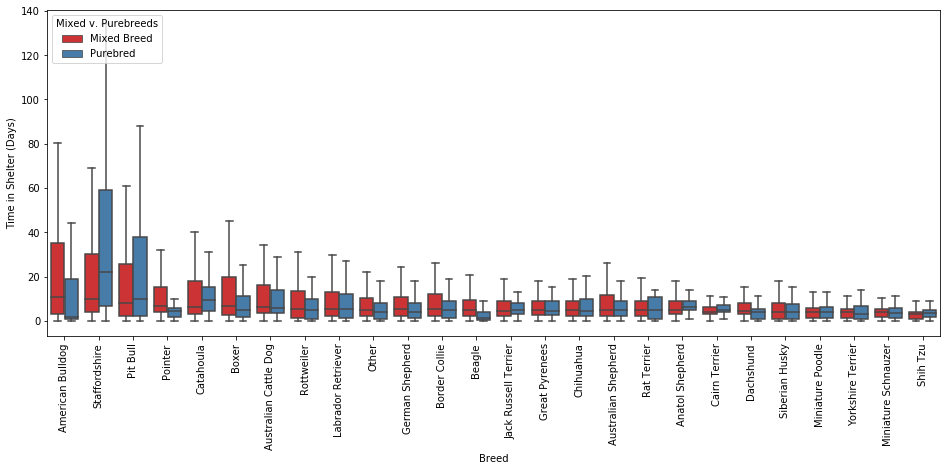

In [123]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='breed_category', y='time_in_shelter_days', hue='mixed_breed', 
                    data=dog_breeds, palette='Set1', showfliers=False, order=sortgroup)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.legend(title='Mixed v. Purebreeds', loc='upper left')
plt.xticks(rotation=90)

# Do certain breed groups have longer adoption times?

### AKC groupings include the Hound Group, Terrier Group, Working Group, Herding Group, Sporting Group, Non-Sporting Group, Toy Group, and Miscellaneous
Here, I pulled data from the [AKC](https://en.wikipedia.org/wiki/List_of_dog_breeds) to categorize dog breeds into breed groups. Breed groups have histories of being bred for similar functions and traits, and here, I've hypothesized that the Working Group has longer adoption times and may be less desirable for families. 

The AKC website describes Working breeds as follows:
> They were developed to assist humans in some capacity – including pulling sleds and carts, guarding flocks and homes, and protecting their families – and many of these breeds are still used as working dogs today. Breeds in the Working Group tend to be known for imposing stature, strength, and intelligence.

More information on AKC breed groupings can be found [here](https://www.akc.org/expert-advice/lifestyle/7-akc-dog-breed-groups-explained/).

In [87]:
dog_groups = pd.read_csv('dogbreed_categories.csv', header=0)
dog_groups = dog_groups[['Breed', 'Origin', 'American Kennel Club[4]', 'United Kennel Club[9]']]

In [24]:
breed_groups = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed', right_on='Breed')
AKCgroups = ['Hound Group', 'Terrier Group', 'Working Group', 'Herding Group', 
             'Sporting Group', 'Non-Sporting Group', 'Toy Group', 'Miscellaneous']
breed_groups = breed_groups[breed_groups['American Kennel Club[4]'].isin(AKCgroups)]

In [106]:
sortbreedgroup = breed_groups.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup = sortbreedgroup['time_in_shelter_days'].to_dict()

## Miscellaneous breeds have the longest adoption times; however, there weren't many dogs falling into this category.
Only the Dogo Argentino and Dutch Shepherd were in this group, and there weren't many to pass through the ACC -  only 7 total.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

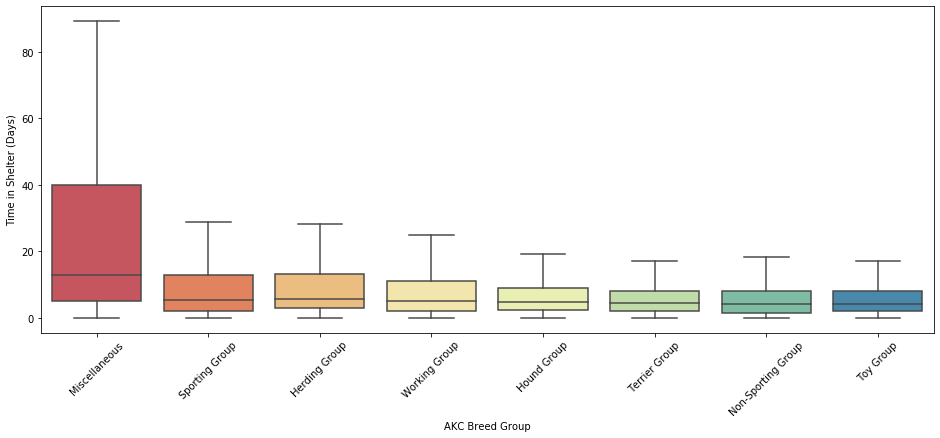

In [132]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Does Breed Group have an effect on adoption time when only commonly occurring breeds are considered?
Only dog breeds that occurred >400 times in the data were considered here.

In [117]:
breed_groups_common = pd.merge(left=dog_breeds, right=dog_groups, left_on='breed_category', right_on='Breed')
breed_groups_common = breed_groups_common[breed_groups_common['American Kennel Club[4]'].isin(AKCgroups)]

In [121]:
sortbreedgroup_common = breed_groups_common.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup_common = sortbreedgroup_common['time_in_shelter_days'].to_dict()

## Sporting, Herding, and Working groups seem to have longer adoption times than Terrier and Toy Groups.
Additionally, there were no commonly occuring breeds that fell into the Miscellaneous and Non-Sporting Group categories.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

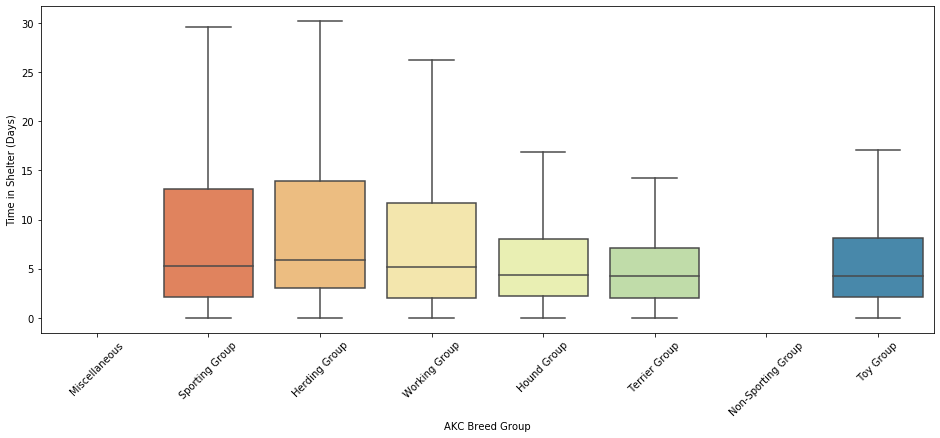

In [133]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups_common, palette='Spectral', showfliers=False, order=sortbreedgroup)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

# Mixed breeds are more likely to have longer adoption times than purebred dogs.

Text(0, 0.5, 'Time in Shelter (Days)')

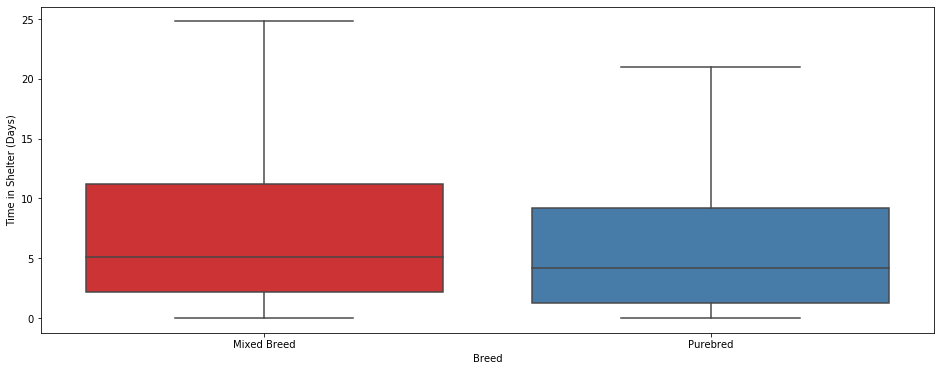

In [134]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='mixed_breed', y='time_in_shelter_days', 
                    data=dog_breeds, palette='Set1', showfliers=False)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')

# Do older dogs have a harder time getting adopted than puppies?
My hypothesis here is that puppies are adopted significantly faster than adult dogs.


<img src="https://www.thelabradorsite.com/wp-content/uploads/2018/05/introducing-puppy-to-older-dog-header-696x377.jpg" width=400px align="center"><br>
[Image Credit](https://www.thelabradorsite.com/introducing-puppy-to-older-dog/)

#### Age is not a continuous variable in this dataset. Even when analyzed by age in days, its rounded up to the year, making it difficult to analyze linearly.

(array([-1000.,     0.,  1000.,  2000.,  3000.,  4000.,  5000.,  6000.,
         7000.,  8000.]), <a list of 10 Text xticklabel objects>)

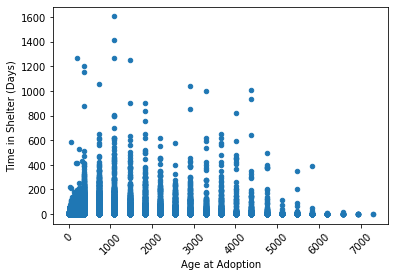

In [129]:
dogs.plot(x='age_upon_outcome_(days)', y='time_in_shelter_days', 
                    kind='scatter') #showfliers=True)
plt.xlabel('Age at Adoption')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Older dogs do not have longer adoption times overall; however, dogs <2.5 years old have a slight advantage over dogs between 2.5 - 5 years old.
Some of this effect may be due to fewer older animals in the shelter: there is less data for older dogs than for young ones.

In [128]:
dogs['age_group'] = dogs['age_upon_outcome_age_group'].str[1:-1]
dogs['age_group'] = dogs['age_group'].str.replace(', ','-')
sortagegroup = dogs['age_group'].value_counts().to_dict()

Text(0, 0.5, 'Time in Shelter (Days)')

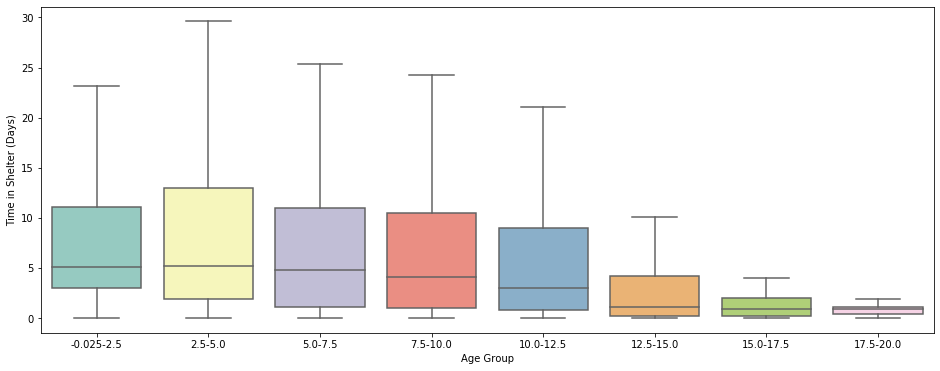

In [206]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='age_group', y='time_in_shelter_days', 
                    data=dogs, palette='Set3', showfliers=False, order=sortagegroup)
plt.xlabel('Age Group')
plt.ylabel('Time in Shelter (Days)')

# Is Black Dog Syndrome occuring at the Austin Animal Shelter?
This phenomenon, described [here](https://en.wikipedia.org/wiki/Black_dog_syndrome), hypothesizes that black dogs are less likely to be adopted than lighter colored dogs. While this phenomenon is widely disputed, several efforts have been made to assist dark-coated dogs with adoption, including the [The Black Dog Project](https://www.fredlevyart.com/index/G00007N.NR0KFZ5I).

As with breed, many dogs had mixed coat colors: there are 337 coat color variations in this dataset. I addressed these the same way as breed, by separating mixed colors and analyzing them separately. 

However, dark colored dogs *do* make up 3 of the 4 most common coat colors: Black/White, Black, and Brown/White.

<img src="http://blog.fredlevyart.com/wp-content/uploads/2014/02/black_dogs-11.jpg" width=400px align="center"><br>
[Image Credit](http://blog.fredlevyart.com/photos/new-blog-black-dog-project)

In [135]:
dogs['color'].nunique()

337

In [137]:
dogs['color'].value_counts().head()

Black/White    5201
Black          2507
Brown/White    2463
Tan/White      2450
White          2366
Name: color, dtype: int64

In [138]:
dogs['coat_color_list'] = dogs['color'].str.split('/')
dogs.loc[dogs.breed_list.str.len()>1, 'multicolor'] = 'Multicolor'
dogs.loc[dogs['color'].str.contains('Tricolor'), 'multicolor'] = 'Multicolor'
dogs['multicolor'] = dogs['multicolor'].fillna('Single Color')

In [33]:
coat_colors = pd.get_dummies(dogs['coat_color_list'].apply(pd.Series).stack()).sum(level=0)

In [139]:
coat_colors_combined = pd.concat([dogs, coat_colors], axis=1)

In [35]:
coat1 = coat_colors_combined[['color', 'coat_color_list', 'multicolor', 'time_in_shelter_days']]
coat2 = coat_colors_combined.loc[:, 'Agouti':]
coat_melt = pd.concat([coat1, coat2], axis=1)
dog_coats = pd.melt(coat_melt, id_vars=['color', 'coat_color_list', 'multicolor','time_in_shelter_days'], 
                       var_name='coat_color', value_name='has_color')
dog_coats.loc[dog_coats['has_color']==1, 'colored'] = dog_coats['coat_color']

Similarly to breed, I grouped all colors that occur <200 times into an "other colors" group.

In [140]:
common_colors = dog_coats.groupby('colored').count()
common_colors = common_colors.sort_values('has_color', ascending=False)
other_colors = common_colors.loc[common_colors['has_color']<200,:]
other_colors_list = other_colors.index.tolist()

In [141]:
dog_coats.loc[dog_coats['colored'].isin(other_colors_list), 'color_category'] = 'Other'
dog_coats.loc[~dog_coats['colored'].isin(other_colors_list), 'color_category'] = dog_coats['colored']

In [145]:
sort_color = dog_coats.groupby('color_category').mean().sort_values('time_in_shelter_days', ascending=False)
sort_color = sort_color['time_in_shelter_days'].to_dict()

## While there were some dark colored dogs that had longer adoption times, there wasn't an obvious pattern here.

Black Brindle is shown below. <br>
<img src="https://cdn.shortpixel.ai/spai/w_1600+q_lossless+ret_img/https://www.k9ofmine.com/wp-content/uploads/2017/03/brindle-dog-breeds.jpg" width=400px align="center"/><br>
[Image Credit](https://www.k9ofmine.com/brindle-dog-breeds/)<br>


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]), <a list of 19 Text xticklabel objects>)

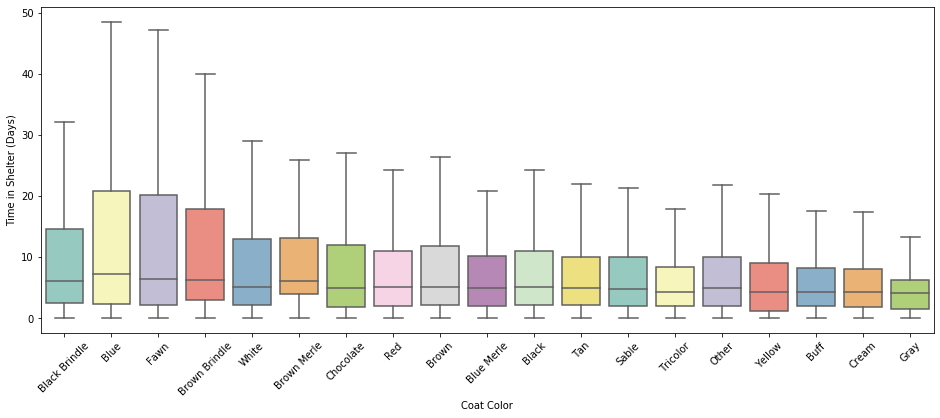

In [156]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='color_category', y='time_in_shelter_days', 
                    data=dog_coats, palette='Set3', showfliers=False, order=sort_color)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Being multicolor versus single colored seems to have almost no affect on adoption time.

Text(0, 0.5, 'Time in Shelter (Days)')

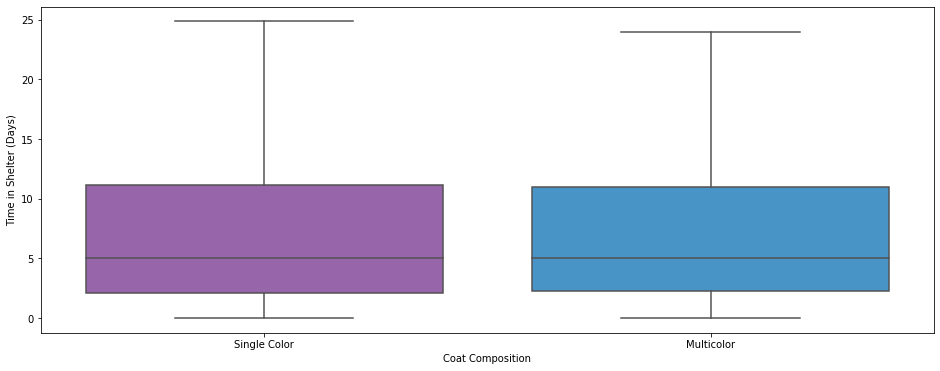

In [226]:
flatui = ["#9b59b6", "#3498db", "#95a5a6", "#e74c3c", "#34495e", "#2ecc71"]
sns.set_palette(flatui)
plt.figure(figsize=(16, 6))
sns.boxplot(x='multicolor', y='time_in_shelter_days',
                    data=dog_coats, palette=flatui, showfliers=False)
plt.xlabel('Coat Composition')
plt.ylabel('Time in Shelter (Days)')

# So, what if we only look at dogs that have long adoption times?
For many of the above boxplots, there were so many outliers that the graphs were impossible to read with outliers shown, as shown here:

Text(0, 0.5, 'Time in Shelter (Days)')

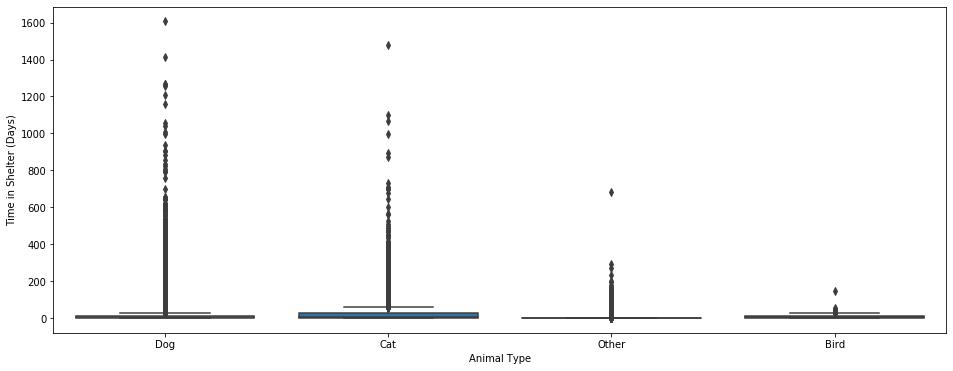

In [169]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', data=df)
plt.xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

# For these outliers (dogs with adoption times >100 days), do breed, mixed breed/purebred status, breed group, age, and coat color affect adoption times?

# Cats may take longer to adopt most of the time, but if an animal is in the shelter for a truly long time, it's more likely to be a dog.
And, apparently, very unlikely to be a bird.

Text(0, 0.5, 'Time in Shelter (Days)')

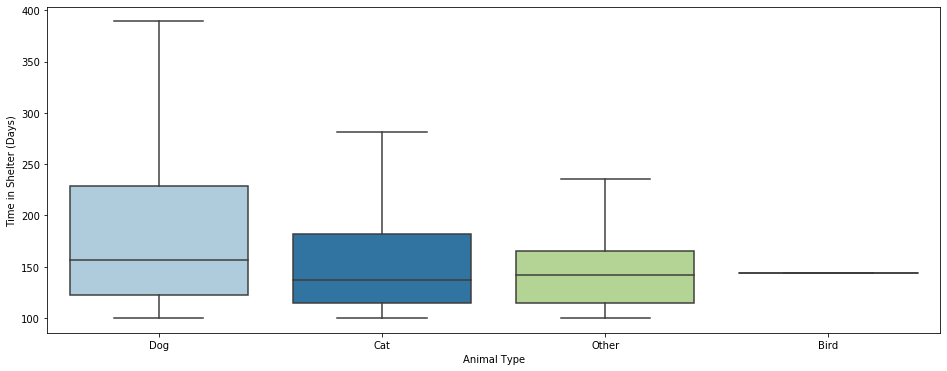

In [170]:
df_outliers = df.loc[df['time_in_shelter_days'] > 100,:]

plt.figure(figsize=(16, 6))
sns.boxplot(x='animal_type', y='time_in_shelter_days', palette='Paired', data=df_outliers, showfliers=False)
plt.xlabel('Animal Type')
plt.ylabel('Time in Shelter (Days)')

## Dogs with outlier adoption times

In [171]:
dog_outliers = df_outliers[df_outliers['animal_type'] == 'Dog']

dog_outliers['breed'] = dog_outliers['breed'].str.replace('Black/Tan Hound', 'Black-Tan Hound')
dog_outliers['breed'] = dog_outliers['breed'].str.replace(' Shorthair', '')
dog_outliers['breed'] = dog_outliers['breed'].str.replace(' Longhair', '')
dog_outliers['breed_nomix'] = dog_outliers['breed'].str.replace(' Mix', '')
dog_outliers['breed_list'] = dog_outliers['breed_nomix'].str.split('/')
dog_outliers.loc[dog_outliers.breed_list.str.len()>1, 'mixed_breed'] = 'Mixed Breed'
dog_outliers.loc[dog_outliers['breed'].str.contains('Mix'), 'mixed_breed'] = 'Mixed Breed'
dog_outliers['mixed_breed'] = dog_outliers['mixed_breed'].fillna('Purebred')

has_breeds_outliers = pd.get_dummies(dog_outliers['breed_list'].apply(pd.Series).stack()).sum(level=0)

breeds_combined_outliers = pd.concat([dog_outliers, has_breeds_outliers], axis=1)

In [42]:
outlier_melt1 = breeds_combined_outliers[['breed_list', 'mixed_breed', 'time_in_shelter_days']]
outlier_melt2 = breeds_combined_outliers.loc[:, 'Akita':]
outlier_melt = pd.concat([outlier_melt1, outlier_melt2], axis=1)
breed_outliers = pd.melt(outlier_melt, id_vars=['breed_list','mixed_breed','time_in_shelter_days'], var_name='breed_name', value_name='has_breed')
breed_outliers.loc[breed_outliers['has_breed']==1, 'breed'] = breed_outliers['breed_name']

As before, there are many cases where animals only appear once or a few times in the data. I grouped breeds that do not appear commonly using quartiles and determined that animals that occur <8 times would be grouped as "other".

In [43]:
breed_outliers.groupby('breed').sum().sort_values('has_breed',ascending=False)['has_breed'].quantile(.75)

7.75

In [44]:
common_breeds_outliers = breed_outliers.groupby('breed').sum()
common_breeds_outliers = common_breeds_outliers.sort_values('has_breed', ascending=False)
other_breeds_outliers = common_breeds_outliers.loc[common_breeds_outliers['has_breed']<8,:]
other_breeds_list_outliers = other_breeds_outliers.index.tolist()

breed_outliers.loc[breed_outliers['breed'].isin(other_breeds_list_outliers), 'breed_category'] = 'Other'
breed_outliers.loc[~breed_outliers['breed'].isin(other_breeds_list_outliers), 'breed_category'] = breed_outliers['breed']

# Dachshunds, American Bulldogs, and Catahoulas have the longest adoption times of dogs in this outlier group.
Note that purebreds almost never appear in this outlier group: only 65 of these datapoints are purebreds.


<img src="https://dogsaholic.com/wp-content/uploads/2018/02/главная-5.jpg" width=400px align="center"><br>
[Image Credit](https://dogsaholic.com/names/dachshund-names.html)<br>


In [174]:
sortgroup_outliers = breed_outliers.groupby('breed_category').mean().sort_values('time_in_shelter_days', ascending=False)
sortgroup_outliers = sortgroup_outliers['time_in_shelter_days'].to_dict()

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25]),
 <a list of 26 Text xticklabel objects>)

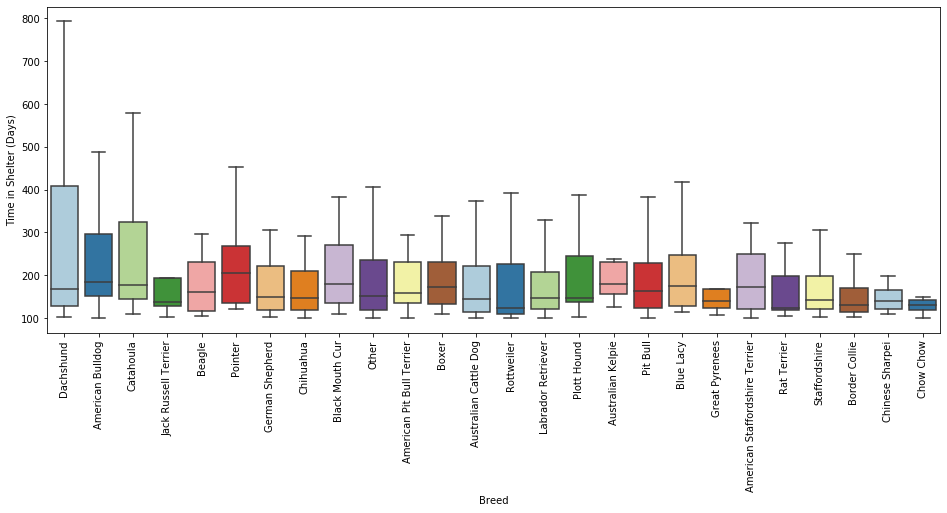

In [180]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='breed_category', y='time_in_shelter_days', 
                    data=breed_outliers, palette='Paired', showfliers=False, order=sortgroup_outliers)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=90)

# The Hound Group has the longest adoption times in dogs that have excessively long adoption times. Additionally, the Toy Group is more highly represented in these outliers.
It's worth noting here that Dachshunds are part of the Hound Group, so this makes sense.

This time, I only looked based on the breed group categorizations determined above: breeds appearing <8 times were grouped together as "other".

In [182]:
breed_groups_outliers = pd.merge(left=breed_outliers, right=dog_groups, left_on='breed_category', right_on='Breed')
breed_groups_outliers = breed_groups_outliers[breed_groups_outliers['American Kennel Club[4]'].isin(AKCgroups)]

In [187]:
sortbreedgroup_outliers = breed_groups_outliers.groupby('American Kennel Club[4]').mean().sort_values('time_in_shelter_days', ascending=False)
sortbreedgroup_outliers = sortbreedgroup_outliers['time_in_shelter_days'].to_dict()

(array([0, 1, 2, 3, 4, 5, 6]), <a list of 7 Text xticklabel objects>)

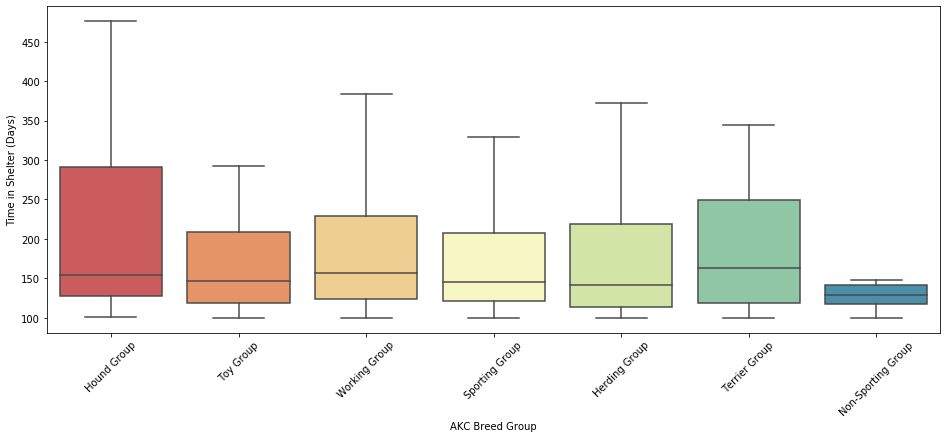

In [194]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='American Kennel Club[4]', y='time_in_shelter_days', 
                    data=breed_groups_outliers, palette='Spectral', showfliers=False, order=sortbreedgroup_outliers)
plt.xlabel('AKC Breed Group')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

# Purebreds are significantly underrepresented in outliers, and mixed breeds still have longer adoption times.

Text(0, 0.5, 'Time in Shelter (Days)')

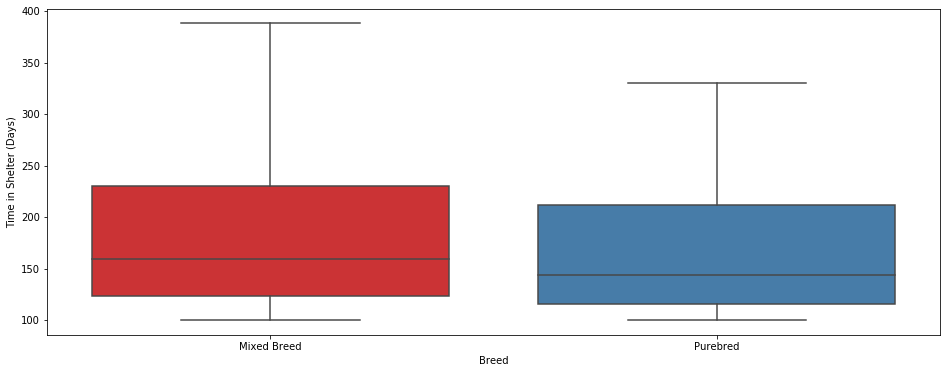

In [193]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='mixed_breed', y='time_in_shelter_days', 
                    data=breed_outliers, palette='Set1', showfliers=False)
plt.xlabel('Breed')
plt.ylabel('Time in Shelter (Days)')

# Age is a much larger factor for dogs that have long adoption times.
Here, it is easy to see that younger dogs are adopted more quickly.

In [201]:
dog_outliers['age_group'] = dog_outliers['age_upon_outcome_age_group'].str[1:-1]
dog_outliers['age_group'] = dog_outliers['age_group'].str.replace(', ','-')
sortagegroup_outliers = dog_outliers.groupby('age_group').mean().sort_values('time_in_shelter_days', ascending=False)
sortagegroup_outliers = sortagegroup_outliers['time_in_shelter_days'].to_dict()

Text(0, 0.5, 'Time in Shelter (Days)')

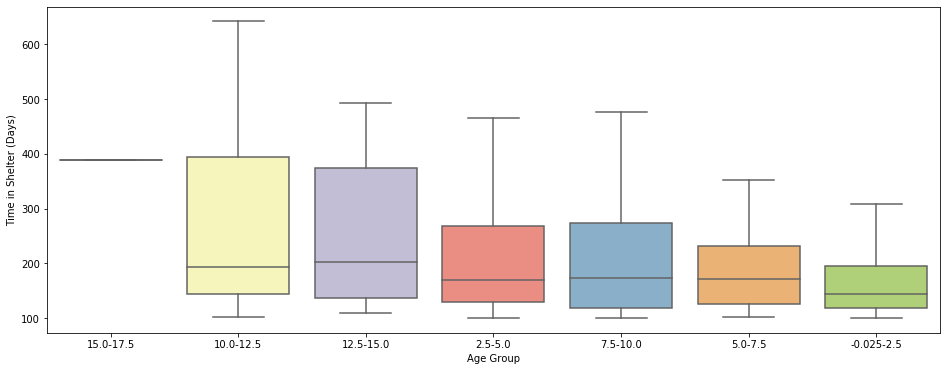

In [205]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='age_group', y='time_in_shelter_days', 
                    data=dog_outliers, palette='Set3', showfliers=False, order=sortagegroup_outliers)
plt.xlabel('Age Group')
plt.ylabel('Time in Shelter (Days)')

## Is Black Dog Syndrome more prevalent in dogs with long adoption times?
As before, I parsed mixed coat colors to look at individual colors separately.

In [207]:
dog_outliers['coat_color_list'] = dog_outliers['color'].str.split('/')
dog_outliers.loc[dog_outliers.breed_list.str.len()>1, 'multicolor'] = 'Multicolor'
dog_outliers.loc[dog_outliers['color'].str.contains('Tricolor'), 'multicolor'] = 'Multicolor'
dog_outliers['multicolor'] = dog_outliers['multicolor'].fillna('Single Color')
coat_colors_outliers = pd.get_dummies(dog_outliers['coat_color_list'].apply(pd.Series).stack()).sum(level=0)

In [55]:
coat_colors_combined_outliers = pd.concat([dog_outliers, coat_colors_outliers], axis=1)

In [56]:
coat1_outliers = coat_colors_combined_outliers[['color', 'coat_color_list', 'multicolor', 'time_in_shelter_days']]
coat2_outliers = coat_colors_combined_outliers.loc[:, 'Apricot':]
coat_melt_outliers = pd.concat([coat1_outliers, coat2_outliers], axis=1)
dog_coats_outliers = pd.melt(coat_melt_outliers, id_vars=['color', 'coat_color_list', 'multicolor','time_in_shelter_days'], 
                       var_name='coat_color', value_name='has_color')
dog_coats_outliers.loc[dog_coats_outliers['has_color']==1, 'colored'] = dog_coats_outliers['coat_color']

Similarly to breed in this outlier group, I used quartiles to determine how to group "other" colors (less frequently occuring colors).

In [208]:
common_colors_outliers = dog_coats_outliers.groupby('colored').count()
common_colors_outliers = common_colors_outliers.sort_values('has_color', ascending=False)
other_colors_outliers = common_colors_outliers.loc[common_colors_outliers['has_color']<60,:]
other_colors_list_outliers = other_colors_outliers.index.tolist()

In [58]:
dog_coats_outliers.loc[dog_coats_outliers['colored'].isin(other_colors_list_outliers), 'color_category'] = 'Other'
dog_coats_outliers.loc[~dog_coats_outliers['colored'].isin(other_colors_list_outliers), 'color_category'] = dog_coats_outliers['colored']

In [209]:
sort_color_outliers = dog_coats_outliers.groupby('color_category').mean().sort_values('time_in_shelter_days', ascending=False)
sort_color_outliers = sort_color_outliers['time_in_shelter_days'].to_dict()

# Dark coat colors do appear in dogs with longer adoption times; however, they are not significantly longer than light colors.

(array([0, 1, 2, 3, 4, 5, 6, 7]), <a list of 8 Text xticklabel objects>)

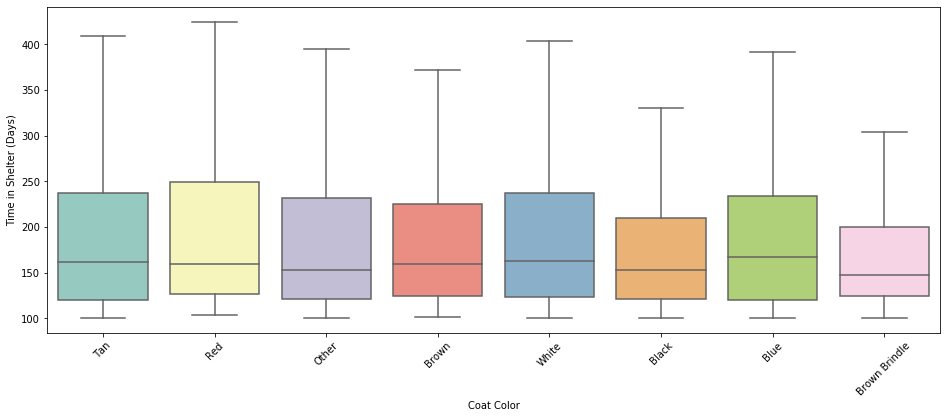

In [275]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='color_category', y='time_in_shelter_days',
                    data=dog_coats_outliers, palette='Set3', showfliers=False, order=sort_color_outliers)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')
plt.xticks(rotation=45)

## Having a single color vs. multicolor coat also does not affect adoption time in dogs with long adoption times.

Text(0, 0.5, 'Time in Shelter (Days)')

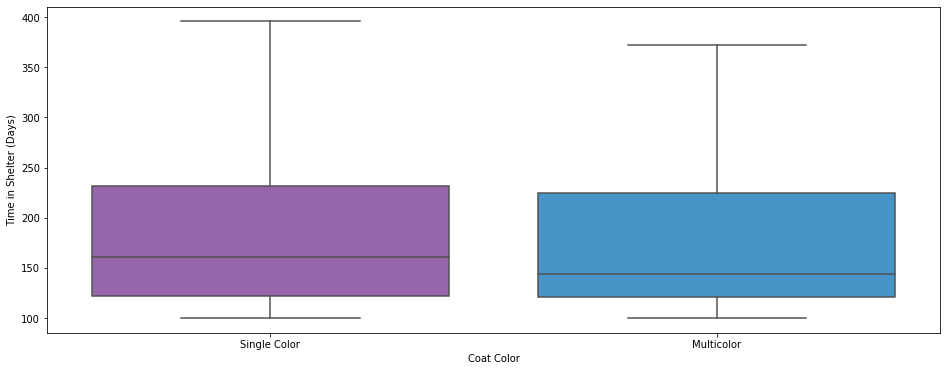

In [221]:
plt.figure(figsize=(16, 6))
sns.boxplot(x='multicolor', y='time_in_shelter_days',
                    data=dog_coats_outliers, palette=flatui, showfliers=False)
plt.xlabel('Coat Color')
plt.ylabel('Time in Shelter (Days)')

# Spring into Summer tends to have higher adoption rates than other times of year, although trends vary significantly day-to-day.

In [305]:
dog_times = dogs.set_index('outcome_datetime')
dog_times = dog_times.sort_index()
dog_times['adoption_count'] = 1
dog_times = dog_times['adoption_count']

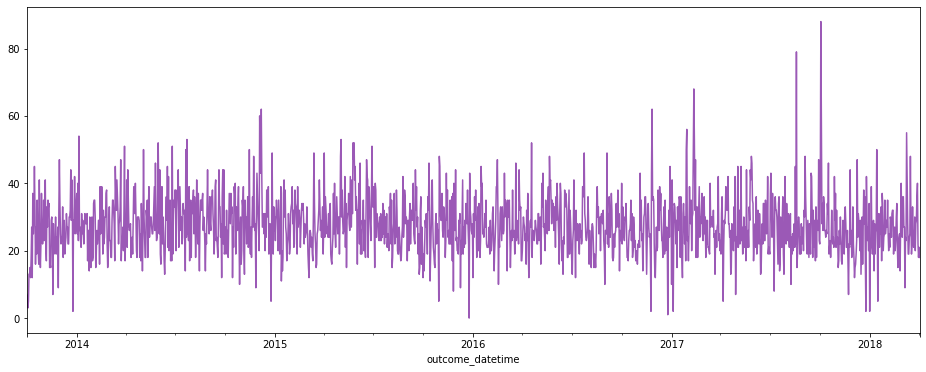

In [306]:
plt.figure(figsize=(16, 6))
dog_times.resample('1D').count().plot()

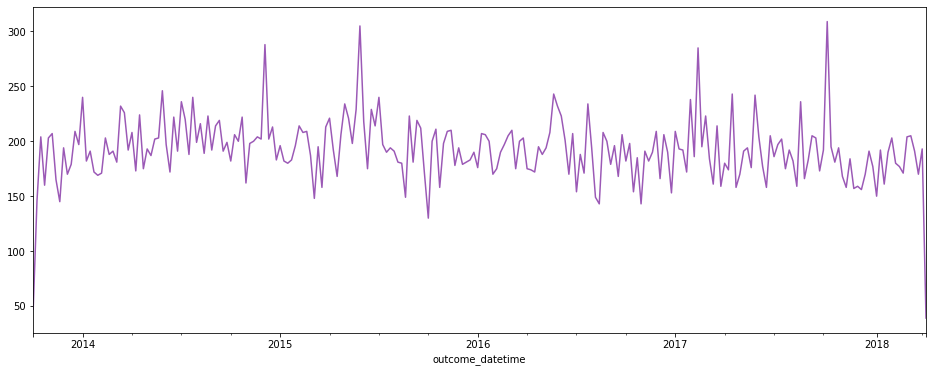

In [307]:
plt.figure(figsize=(16, 6))
dog_times.resample('1W').count().plot()

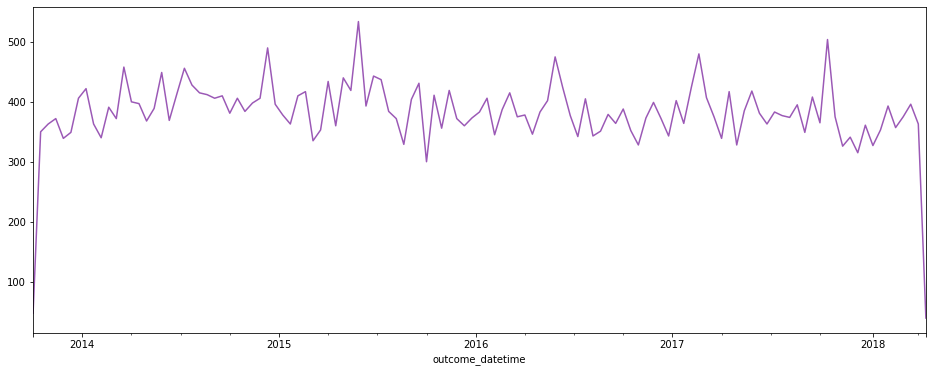

In [318]:
plt.figure(figsize=(16, 6))
dog_times.resample('2W').count().plot()

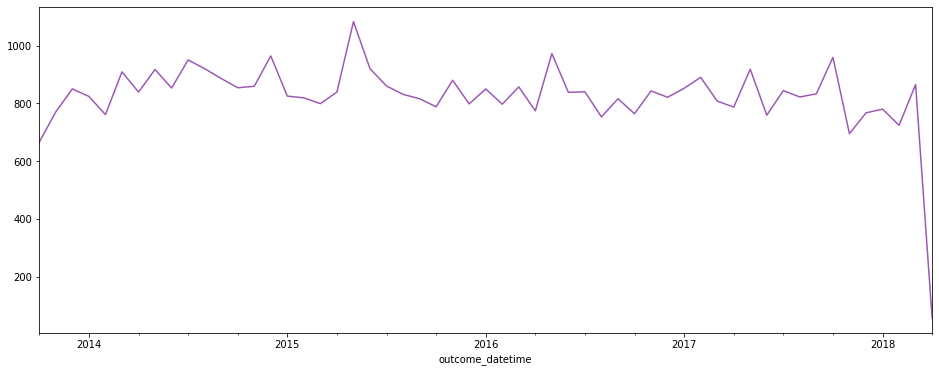

In [308]:
plt.figure(figsize=(16, 6))
dog_times.resample('1M').count().plot()

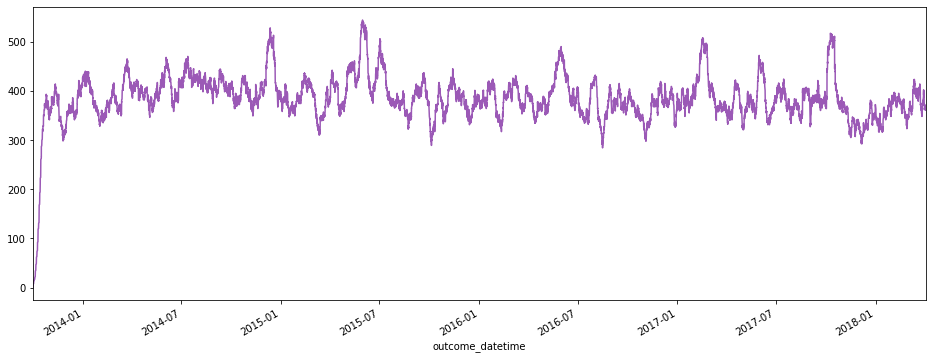

In [317]:
plt.figure(figsize=(16, 6))
dog_times.rolling('14D').sum().plot()